<a href="https://colab.research.google.com/github/Saadman53/Thesis-Human-Activity-Recognition/blob/Defense/Classification%20CCA_Fusion(Sens%2BDMM_Sobel).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install ax-platform

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
import numpy as np
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA
import scipy.io as sio
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time
from statsmodels.multivariate.cancorr import CanCorr

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data

from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import torch.optim as optim
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render
from ax.utils.tutorials.cnn_utils import train, evaluate


import torchvision
import torchvision.transforms as transforms



import random
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report


from torch.utils.data import DataLoader, ConcatDataset
# from torchvision import transforms
from sklearn.model_selection  import StratifiedKFold

import torch.optim.lr_scheduler as lr_scheduler
%matplotlib inline

import scipy.io as sio
torch.autograd.set_detect_anomaly(True)


from functools import partial
from typing import Any, Optional

import torch
import torch.nn as nn
#stats_cca = CanCorr(Y_train, X_train)

# print(stats_cca.corr_test().summary())
# X_train_c = stats_cca.x_cancoef
# Y_train_c = stats_cca.y_cancoef

In [51]:
gdrive_path = "drive/My Drive/Dataset/Final Dataset/Train Test Set/alexnet_DMM_Sobel_train_test_set.mat"
sensor_path = "drive/My Drive/Dataset/Final Dataset/Train Test Set/sensor_features_acc_gyro_experimental.mat"

In [52]:
dat1 = sio.loadmat(gdrive_path)
dat2 = sio.loadmat(sensor_path)

In [53]:
X_train1 = dat1['X_train']
X_test1 = dat1['X_test']
X_val1 = dat1['X_val']
X_train2 = dat2['X_train']
X_test2 = dat2['X_test']
X_val2 = dat2['X_val']

y_train = dat1['y_train'].ravel()
y_test = dat1['y_test'].ravel()
y_val = dat1['y_val'].ravel()

In [55]:
def CCAFusion(train_X, train_Y, test_X, test_Y, val_X, val_Y):
    n,p = train_X.shape
    q   = train_Y.shape[1]
    n_components = min(n,p,q)
    
    sc1 = StandardScaler()
    train_X = sc1.fit_transform(train_X)
    test_X = sc1.transform(test_X)
    val_X = sc1.transform(val_X)
    
    sc2 = StandardScaler()
    train_Y = sc2.fit_transform(train_Y)
    test_Y = sc2.transform(test_Y)
    val_Y = sc2.transform(val_Y)

    ca = CCA(n_components)
    ca.fit(train_X, train_Y)
    train_X, train_Y = ca.transform(train_X, train_Y)
    test_X, test_Y = ca.transform(test_X, test_Y)
    val_X, val_Y = ca.transform(val_X, val_Y)
    return train_X+train_Y, test_X+test_Y, val_X+val_Y

In [56]:
start = time.time()
X_train,X_test,X_val = CCAFusion(X_train1, X_train2, X_test1, X_test2, X_val1, X_val2)
end = time.time()
print(f"It took {end-start} seconds to CCA Fuse.")

It took 1030.519058227539 seconds to CCA Fuse.


In [57]:
print(X_train.shape,X_test.shape,X_val.shape)

(742, 417) (291, 417) (131, 417)


In [58]:
def train_test_loader(X_train, X_test, y_train, y_test):
  scaler = StandardScaler()
  train_X = X_train.copy()
  test_X = X_test.copy()
  train_X = scaler.fit_transform(train_X)
  test_X = scaler.transform(test_X)
  train_dataset = TensorDataset(Tensor(train_X), Tensor(y_train))
  test_dataset = TensorDataset(Tensor(test_X), Tensor(y_test))
  test_loader = DataLoader(test_dataset, batch_size= 64)
  return train_dataset, test_loader

In [59]:
class DNN(nn.Module):
    def __init__(self,input_size,output_size):
        super(DNN,self).__init__()
        self.hidden1 = nn.Linear(input_size,128)
        self.hidden2 = nn.Linear(128,64)
        self.hidden3 = nn.Linear(64,32)
        self.output = nn.Linear(32,output_size)
        self.softmax = F.softmax
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(128)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.batchnorm3 = nn.BatchNorm1d(32)
    
    def forward(self,x):
        out = self.hidden1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        
        out = self.hidden2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.hidden3(out)
        out = self.batchnorm3(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.output(out)
        return out

In [60]:
def net_train(net, train_loader, parameters):
  criterion = nn.CrossEntropyLoss(reduction = "sum")
  optimizer = optim.SGD(net.parameters(), # or any optimizer you prefer 
                        lr=parameters.get("lr", 0.001), # 0.001 is used if no lr is specified
                        momentum=parameters.get("momentum", 0.9)
  )

  scheduler = optim.lr_scheduler.StepLR(
      optimizer,
      step_size=int(parameters.get("step_size", 30)),
      gamma=1.0,  # default is no learning rate decay
  )

  num_epochs = parameters.get("max_epoch", 3) # Play around with epoch number
  # Train Network
  for _ in range(num_epochs):
    for inputs, labels in train_loader:
      # zero the parameter gradients
      optimizer.zero_grad()
      # forward + backward + optimize
      outputs = net(inputs)
      loss = criterion(outputs, labels.long())
      loss.backward()
      optimizer.step()
      scheduler.step()
  return net

In [61]:
def train_evaluate(parameterization):
    # constructing a new training data loader allows us to tune the batch size
    train_loader = torch.utils.data.DataLoader(train_set,
                                batch_size=parameterization.get("batchsize", 32),
                                shuffle=True,
                                num_workers=0,
                                pin_memory=True,drop_last=True)
    
    # Get neural net
    untrained_net = DNN(inpsize,outsize)
    # train
    trained_net = net_train(net=untrained_net, train_loader=train_loader, 
                            parameters=parameterization)
    # return the accuracy of the model as it was trained in this run
    return evaluate(
        net=trained_net,
        data_loader=test_loader,
        dtype = torch.float,
        device = "cpu"
    )

In [62]:
train_set, test_loader = train_test_loader(X_train, X_val, y_train, y_val)
inpsize = X_train.shape[1]
outsize = np.unique(y_train).shape[0]
dtype = torch.float
best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "lr", "type": "range", "bounds": [1e-4, 0.2], "log_scale": True},
        {"name": "batchsize", "type": "range", "bounds": [20, 150]},
        {"name": "momentum", "type": "range", "bounds": [0.0, 1.0]},    
        {"name": "max_epoch", "type": "range", "bounds": [10, 100]},
        {"name": "stepsize", "type": "range", "bounds": [20, 40]},     
    ],
  
    evaluation_function=train_evaluate,
    objective_name='accuracy',
)

print(best_parameters)
means, covariances = values
print(means)
print(covariances)

[INFO 02-07 18:54:52] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-07 18:54:52] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter batchsize. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-07 18:54:52] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter momentum. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-07 18:54:52] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter max_epoch. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter di

{'lr': 0.004060565103451759, 'batchsize': 48, 'momentum': 0.3407983122201955, 'max_epoch': 100, 'stepsize': 39}
{'accuracy': 0.8441150780110822}
{'accuracy': {'accuracy': 0.002677444118824536}}


In [64]:
best_parameters

{'lr': 0.004060565103451759,
 'batchsize': 48,
 'momentum': 0.3407983122201955,
 'max_epoch': 100,
 'stepsize': 39}

In [65]:
best_objectives = np.array([[trial.objective_mean*100 for trial in experiment.trials.values()]])

best_objective_plot = optimization_trace_single_method(
    y=np.maximum.accumulate(best_objectives, axis=1),
    title="Model performance vs. # of iterations",
    ylabel="Classification Accuracy, %",
)
render(best_objective_plot)

render(plot_contour(model=model, param_x='batchsize', param_y='lr', metric_name='accuracy'))

In [26]:
data = experiment.fetch_data()
dff = data.df
best_arm_name = dff.arm_name[dff['mean'] == dff['mean'].max()].values[0]
best_arm = experiment.arms_by_name[best_arm_name]
best_arm

Arm(name='6_0', parameters={'lr': 0.008840128449936306, 'batchsize': 135, 'momentum': 0.6841613678261638, 'max_epoch': 53, 'stepsize': 36})

In [66]:
def optim_scheduler(net,parameters):
  optimizer = optim.SGD(net.parameters(), # or any optimizer you prefer 
                        lr=parameters.get("lr", 0.001), # 0.001 is used if no lr is specified
                        momentum=parameters.get("momentum", 0.9)
  )
  scheduler = optim.lr_scheduler.StepLR(
      optimizer,
      step_size=int(parameters.get("step_size", 30)),
      gamma=1.0,  # default is no learning rate decay
  )
  return optimizer, scheduler
def extract_batch(X,y,batch_size,step,no_of_samples):
  l = (step-1)*batch_size
  return X[l:(l+batch_size)],y[l:min(no_of_samples,l+batch_size)]

def model_training_evaluation(X_train, X_test, y_train, y_test):
  train_X = X_train
  test_X = X_test
  scaler = StandardScaler()
  train_X = scaler.fit_transform(train_X)
  test_X = scaler.transform(test_X)
  train_X = torch.from_numpy(train_X.astype(np.float32))
  test_X = torch.from_numpy(test_X.astype(np.float32))
  train_y =  torch.tensor(y_train.astype(np.float32))
  test_y =  torch.tensor(y_test.astype(np.float32))
  input_size = train_X.shape[1]
  output_size = torch.unique(train_y).shape[0]
  learning_rate = best_parameters['lr']
  num_epochs = best_parameters['max_epoch']
  n_samples = train_X.shape[0]
  criterion = nn.CrossEntropyLoss(reduction='sum')
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
  net = DNN(input_size, output_size)
  optimizer, scheduler = optim_scheduler(net,best_parameters)
  figure, ax = plt.subplots(5,figsize=(10,10))
  figure.tight_layout(pad=5.0)
  cnt = 1
  best_loss = 100000
  best_model = None
  best_epoch = None
  for train_index, val_index in skf.split(X_train, y_train):
    train_X_fold = train_X[train_index]
    train_y_fold = train_y[train_index]
    val_x_fold = train_X[val_index]
    val_y_fold = train_y[val_index]
    n_samples = train_X_fold.shape[0]
    batch_size = best_parameters['batchsize']
    train_loss = []
    val_loss = []
    print(f"Training for fold {cnt}")
    for epoch in range(num_epochs):
      step = 1
      while(batch_size*step<=n_samples):
        x,y =  extract_batch(train_X_fold,train_y_fold, batch_size, step, n_samples)
        # Forward Propagation
        y_predicted = net(x)
        loss = criterion(y_predicted,  torch.tensor(y, dtype=torch.long))
        # Backward propagation and update
        loss.backward()
        optimizer.step()
        scheduler.step()
        # Performing zero grad before new step
        optimizer.zero_grad()
        step = step+1
      t_loss = criterion( net(train_X_fold),  torch.tensor(train_y_fold, dtype=torch.long)).item()/train_X_fold.shape[0]
      v_loss = criterion( net(val_x_fold),  torch.tensor(val_y_fold, dtype=torch.long)).item()/val_x_fold.shape[0]
      train_loss.append(t_loss) 
      val_loss.append(v_loss)
      if(v_loss<best_loss):
        best_loss = v_loss
        best_model = net
        best_epoch = epoch
      print(epoch*100/num_epochs)
    m = "Fold "+str(cnt)
    ax[cnt-1].title.set_text(m)
    ax[cnt-1].set_ylabel("Total Loss")
    ax[cnt-1].set_xlabel("No of Epochs")
    ax[cnt-1].plot(range(num_epochs),train_loss, label = "train loss")
    ax[cnt-1].plot(range(num_epochs),val_loss, label = "validation loss")
    cnt+=1
  y_pred = best_model(test_X)
  return best_model, y_pred


Training for fold 1
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
Training for fold 2
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0


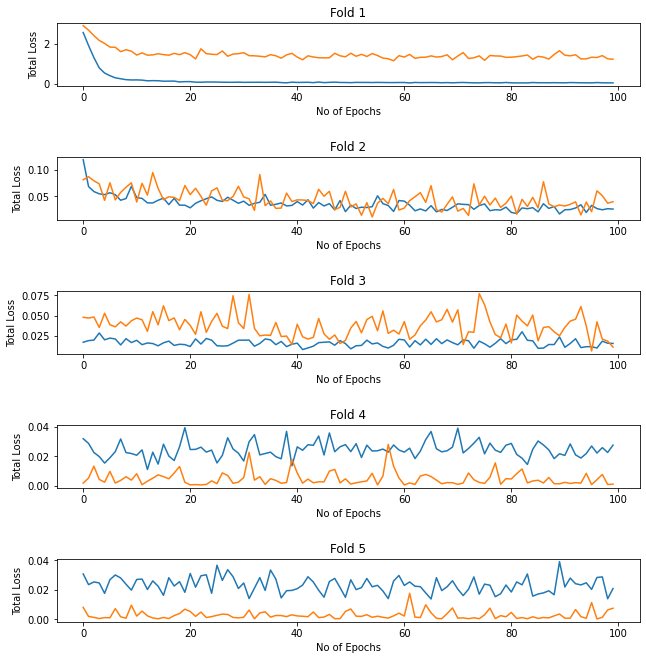

In [67]:
start = time.time()
best_model, y_pred = model_training_evaluation(X_train, X_test, y_train, y_test)
end = time.time()
training_time = end - start

In [68]:
print(f"Time took to train {training_time} seconds")

Time took to train 88.0330274105072 seconds


In [69]:
def cf_matrix(y_pred, test_y):
  y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
  _, y_pred = torch.max(y_pred_softmax, dim = 1)
  y_pred = y_pred.detach().numpy().ravel()
  correct_pred = (y_pred == test_y).astype(np.float)
  acc = correct_pred.sum()*100.0 / y_pred.shape[0]
  cm = confusion_matrix(test_y.ravel(), y_pred)
  recall = np.mean(recall_score(test_y.ravel(), y_pred, average=None))*100.0
  precision = np.mean(precision_score(test_y.ravel(), y_pred, average=None))*100.0
  f1 = 2*((precision*recall*1.0)/(precision+recall))
  f,ax=plt.subplots(figsize=(20,10))
  sns.heatmap(cm,annot=True,fmt='.0f', cmap="Blues")
  print(f"Accuracy: {acc:.2f}%")
  print(f"Precision: {precision:.2f}%")
  print(f"Recall: {recall:.2f}%")
  print(f"F1 score: {f1:.2f}%")
  plt.ylabel('Actual Values')
  plt.xlabel('Predicted Values')
  plt.show()
  return cm,acc, recall, precision, f1


Accuracy: 86.25%
Precision: 86.40%
Recall: 86.11%
F1 score: 86.25%


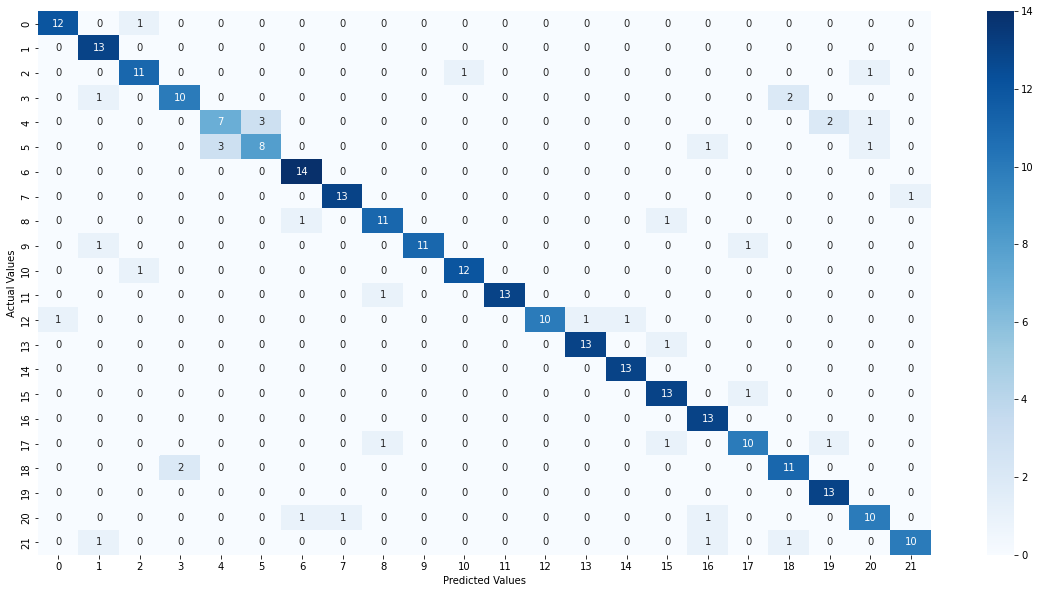

In [70]:
cm,acc, recall, precision,f1 = cf_matrix(y_pred, y_test)

In [71]:
pred_dict = {"preds":y_pred.detach().numpy(), 'y_test':y_test.ravel()}
sio.savemat("drive/My Drive/Dataset/Final Dataset/Predictions/FF_(acc+gyro+DMM_Sobel)_predictions.mat", pred_dict)

In [72]:
import datetime
ts = str((datetime.datetime.now()).timestamp())
model_save_name = 'FF_(Acc+Gyro+DMM_Sobel)_DNN_'+ts+'_.pt'
path = F"drive/My Drive/Dataset/Final Dataset/Models/Feature Fusion/{model_save_name}" 
torch.save(best_model.state_dict(), path)